In [ ]:
payaso = cv.imread("imagenes/chairs.jpg",cv.IMREAD_GRAYSCALE)

payasofft = np.fft.fft2(payaso)
payasofft = np.fft.fftshift(payasofft)
mag,phase = mag_phase(payasofft)

imagen1 = np.real(np.fft.ifft2(np.exp(-1j*phase)))

imagen2 = np.real(np.fft.ifft2(mag))
fig,ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(payaso,cmap="gray")
ax[1].imshow(imagen1,cmap="gray")
ax[2].imshow(imagen2,cmap="gray")
plt.show()

In [ ]:
from __future__ import division
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.stats
import math


def optimalDFTImg(img):
    """Zero-padding sobre img para alcanzar un tamaño óptimo para FFT"""
    h=cv.getOptimalDFTSize(img.shape[0])
    w=cv.getOptimalDFTSize(img.shape[1])
    return cv.copyMakeBorder(img,0,h-img.shape[0],0,w-img.shape[1],cv.BORDER_CONSTANT)

def spectrum(img):
    """Calcula y muestra el módulo logartímico de la DFT de img."""
    #img=optimalDFTImg(img)
    
    imgf=cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT) 
    modulo = np.log(cv.magnitude(imgf[:,:,0],imgf[:,:,1])+1)
    modulo = np.fft.fftshift(modulo) 
    modulo=cv.normalize(modulo, modulo, 0, 1, cv.NORM_MINMAX)
    
    return modulo
    # plt.figure()
    # plt.imshow(modulo,cmap='gray')
    # plt.show()

def rotate(img,angle):
    """Rotación de la imagen sobre el centro"""
    r=cv.getRotationMatrix2D((img.shape[0]/2,img.shape[1]/2),angle,1.0)
    return cv.warpAffine(img,r,img.shape)

def filterImg(img,filtro_magnitud):
    """Filtro para imágenes de un canal"""
    
    
    #como la fase del filtro es 0 la conversión de polar a cartesiano es directa (magnitud->x, fase->y)
    filtro=np.array([filtro_magnitud,np.zeros(filtro_magnitud.shape)]).swapaxes(0,2).swapaxes(0,1)
    imgf=cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
   
    imgf=cv.mulSpectrums(imgf, np.float32(filtro), cv.DFT_ROWS)
    
    return cv.idft(imgf, flags=cv.DFT_REAL_OUTPUT | cv.DFT_SCALE)



def dist(a,b):
    """distancia Euclidea"""
    return np.linalg.norm(np.array(a)-np.array(b))

def filterGaussian(rows,cols,corte):
    """Filtro de magnitud gausiano"""

    magnitud = np.zeros((rows, cols))

    corte *= rows
    for k in range(rows):
        for l in range(cols):
            magnitud[k,l]=np.exp(-dist([k+.5,l+.5],[rows/2,cols/2])/2/corte/corte)
            
    return np.fft.fftshift(magnitud)
    
        
def filterIdeal(rows, cols, corte):
    """filtro de magnitud ideal"""
    magnitud = np.zeros((rows, cols))
    if cols%2==1 and rows%2==1: #impar, el centro cae en un píxel
        print('entro')
        magnitud=cv.circle(magnitud, (cols/2,rows/2), rows*corte, 1, -1)
    else:
        limit = (corte*rows)**2
        for k in range(rows):
            for l in range(cols):
                d2 = dist([k+.5,l+.5],[rows/2,cols/2])
                if d2 <= limit: 
                    magnitud[k,l] = 1
    return np.fft.fftshift(magnitud)
	
def filterButterworth(rows, cols, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[rows/2,cols/2])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return np.fft.fftshift(magnitud)

    
def motionBlur(size, a,  b):
    """Filtro de movimiento en direcciones a y b"""
    transformation =np.zeros(size)
    rows = size[0]
    cols = size[1]

    #fase exp(j\pi (ua + vb))
    #magnitud \frac{ \sin(\pi(ua+vb)) }{ \pi (ua+vb) }
    for k in range(rows):
        for l in range(cols):
            u = (l-cols/2)/cols
            v = (k-rows/2)/rows

            pi_v = math.pi*(u*a+v*b);
            if pi_v:
                mag = np.sin(pi_v)/pi_v
            else:
                mag=1 #lim{x->0} sin(x)/x
            
            transformation[k,l] = mag*np.exp(complex(0,1)*pi_v);
			

    return np.fft.fftshift(transformation)


FILTROS PASA BAJOS

In [ ]:
imagen = cv.imread("imagenes/clown.jpg",cv.IMREAD_GRAYSCALE)

Hl = filterIdeal(imagen.shape[0],imagen.shape[1],0.017)
Hb = filterButterworth(imagen.shape[0],imagen.shape[1],0.017,5)
Hg = filterGaussian(imagen.shape[0],imagen.shape[1],0.017)

imagen_lineal=filterImg(imagen,H)
imagen_buter=filterImg(imagen,Hb)
imagen_gauss=filterImg(imagen,Hg)

hg = np.zeros((35,35))
corte = 1
for k in range(hg.shape[0]):
        for l in range(hg.shape[1]):
            hg[k,l]=np.exp(-dist([k+.5,l+.5],[hg.shape[0]/2,hg.shape[1]/2])/2/corte/corte)

hg = cv.resize(hg,[imagen.shape[0],imagen.shape[1]])
            
dst = np.fft.fft2(hg)
dst = np.fft.fftshift(dst)
hg_fft = cv.magnitude(np.real(dst),np.imag(dst))

fig,ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].imshow(Hl,cmap="gray")
ax[0,1].imshow(imagen_lineal,cmap="gray")
ax[1,0].imshow(Hb,cmap="gray")
ax[1,1].imshow(imagen_buter,cmap="gray")
ax[2,0].imshow(hg,cmap="gray")
ax[2,1].imshow(hg_fft,cmap="gray")
plt.show()



In [ ]:
imagen = cv.imread("imagenes/clown.jpg",cv.IMREAD_GRAYSCALE)

Hl = filterIdeal(imagen.shape[0],imagen.shape[1],0.023)
Hl = np.abs(Hl-1)

Hb = filterButterworth(imagen.shape[0],imagen.shape[1],0.023,5)
Hb = np.abs(Hb-1)

Hg = filterGaussian(imagen.shape[0],imagen.shape[1],0.023)
Hg = np.abs(Hg-1)

imagen_lineal=filterImg(imagen,Hl)
imagen_buter=filterImg(imagen,Hb)
imagen_gauss=filterImg(imagen,Hg)

hg = np.zeros((35,35))
corte = 9
for k in range(hg.shape[0]):
        for l in range(hg.shape[1]):
            hg[k,l]=np.exp(-dist([k+.5,l+.5],[hg.shape[0]/2,hg.shape[1]/2])/2/corte/corte)

hg = cv.resize(hg,[imagen.shape[0],imagen.shape[1]])
hg = np.abs(1-hg)
            
dst = np.fft.fft2(hg)
dst = np.fft.fftshift(dst)
hg_fft = cv.magnitude(np.real(dst),np.imag(dst))


fig,ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].imshow(Hl,cmap="gray")
ax[0,1].imshow(imagen_lineal,cmap="gray")
ax[1,0].imshow(Hb,cmap="gray")
ax[1,1].imshow(imagen_buter,cmap="gray")
ax[2,0].imshow(Hg,cmap="gray")
ax[2,1].imshow(imagen_gauss,cmap="gray")
plt.show()

In [ ]:
def homomorphicFilter(rows,cols,YR,YI,D0):
    a = rows//2
    b = cols//2
    x, y = np.meshgrid(np.linspace(-b,b,cols), np.linspace(-a,a,rows))
    D = np.sqrt(x*x+y*y)
    Hh = (YR-YI)*(1 - np.exp(-( D**2 / ( 2.0 * D0**2 ) ) ))+YI
    return np.fft.fftshift(Hh)

In [ ]:
casilla = cv.imread("imagenes/casilla.tif",cv.IMREAD_GRAYSCALE)
D0 = 3
Hh = homomorphicFilter(casilla.shape[0],casilla.shape[1],1.5,0.8,0.5)
imagen_homo=filterImg(casilla,Hh)



im_f_HG = np.exp(filterImg(np.log(casilla+10000),Hh))-10000
im_f_HG_n = cv.normalize(im_f_HG, im_f_HG, 0, 255, cv.NORM_MINMAX)


fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(casilla,cmap="gray")
ax[0,1].imshow(casilla,cmap="gray")
ax[1,0].imshow(Hh,cmap="gray")
ax[1,1].imshow(im_f_HG_n,cmap="gray")
# ax[2,0].imshow(Hg,cmap="gray")
# ax[2,1].imshow(imagen_gauss,cmap="gray")
plt.show()

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [ ]:
base = np.zeros((512,512))
H,W=base.shape

tuki = cv.imread('imagenes/tuki.png',cv.IMREAD_GRAYSCALE)
tukifft = np.fft.fft2(tuki)
tukifft = np.fft.fftshift(tukifft)
tukifft = cv.magnitude(np.real(tukifft), np.imag(tukifft))

hori=np.copy(base)



horifft = np.fft.fft2(hori)
horifft = np.fft.fftshift(horifft)
horifft = cv.magnitude(np.real(horifft), np.imag(horifft))


circulo = cv.circle(np.copy(base),(264,264), 10,white,-1)
circlefft = np.fft.fft2(circulo)
circlefft = np.fft.fftshift(circlefft)
circlefft = cv.magnitude(np.real(circlefft), np.imag(circlefft))

rectangulo = cv.rectangle(np.copy(base),(200,200),(206,206),white,-1)
rectfft = np.fft.fft2(rectangulo)
rectfft = np.fft.fftshift(rectfft)
rectfft = cv.magnitude(np.real(rectfft), np.imag(rectfft))

fig,ax=plt.subplots(2,4)
ax[0,0].imshow(hori,cmap="gray",vmin=0,vmax=255)
ax[1,0].imshow(horifft,cmap="gray")

ax[0,1].imshow(circulo,cmap="gray")
ax[1,1].imshow(circlefft,cmap="gray")

ax[0,2].imshow(rectangulo[190:220,190:220],cmap="gray")
ax[1,2].imshow(rectfft,cmap="gray")

ax[0,3].imshow(tuki,cmap="gray")
ax[1,3].imshow(tukifft,cmap="gray")

plt.show()

In [ ]:
zebra = cv.imread("imagenes/imagenB.tif",cv.IMREAD_GRAYSCALE)

zebra_pb = cv.boxFilter(zebra,-1,(3,3))

zebra2=cv.equalizeHist(zebra_pb)


zebra3=cv.equalizeHist(zebra)

zebra3 = cv.boxFilter(zebra3,-1,(5,5))

fig,ax=plt.subplots(2,2, figsize = (10,10))
ax[0,0].imshow(zebra3,cmap="gray")
ax[0,1].imshow(zebra2,cmap="gray")
ax[1,0].hist(zebra3.ravel(),256,[0,256])
ax[1,1].hist(zebra2.ravel(),256,[0,256])
plt.show()

In [ ]:

import numpy as np
#import matplotlib
from matplotlib import pyplot as plt
import cv2 as cv

size = int(512/8)

im = np.zeros((size,size))
centerIm = int(size/2)

im[centerIm-2:centerIm+2:,centerIm-2:centerIm+2:] = 255




dst = np.fft.fft2(im)
dst = np.fft.fftshift(dst)
dst = cv.magnitude( np.real(dst), np.imag(dst))

fig,ax=plt.subplots(1,2,figsize=(30,30))
ax[0].imshow(im,cmap="gray")
ax[1].imshow(dst,cmap="gray")
plt.show()

In [ ]:
import imutils

imagen = np.zeros((512,512))
mitad = int(imagen.shape[1]/2)

imagen[:,mitad]=255
imagen_rot = imutils.rotate(imagen,90)

imagen_sub = imagen[mitad-int(mitad/2):mitad+int(mitad/2),mitad-int(mitad/2):mitad+int(mitad/2)]
imagen_rotsub = imagen_rot[mitad-int(mitad/2):mitad+int(mitad/2),mitad-int(mitad/2):mitad+int(mitad/2)]

dst = np.fft.fft2(imagen_sub)
dst = np.fft.fftshift(dst)
imagen_fft = cv.magnitude(np.real(dst),np.imag(dst))

dst2 = np.fft.fft2(imagen_rotsub)
dst2 = np.fft.fftshift(dst2)
imagen_rotfft = cv.magnitude(np.real(dst2),np.imag(dst2))

fig,ax=plt.subplots(2,2,figsize=(30,30))
ax[0,0].imshow(imagen_sub,cmap="gray")
ax[0,1].imshow(imagen_rotsub,cmap="gray")
ax[1,0].imshow(imagen_fft,cmap="gray")
ax[1,1].imshow(imagen_rotfft,cmap="gray")
plt.show()

In [ ]:
def mag_phase(imagenfft):
    magnitud = np.abs(imagenfft)
    phase = np.arctan2(np.imag(imagenfft),np.real(imagenfft))
    return(magnitud,phase)


In [ ]:
camaleon = cv.imread("imagenes/camaleon.tif",cv.IMREAD_GRAYSCALE)

Hb = filterButterworth(camaleon.shape[0],camaleon.shape[1],0.023,5)
HPA = np.abs(Hb-1)

A = 3
HAP = (A-1) + HPA

a=5
b=4
HEAF = a + b*HPA

camaleon_ttf =  spectrum(camaleon)

camaleon_HAP = filterImg(camaleon,HAP)
camaleon_HEAF = filterImg(camaleon,HEAF)

fig,ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(camaleon,cmap="gray")
ax[0,1].imshow(camaleon_ttf,cmap="gray")

ax[1,0].imshow(camaleon_HAP,cmap="gray")
ax[1,1].imshow(spectrum(camaleon_HAP),cmap="gray")

ax[2,0].imshow(camaleon_HEAF,cmap="gray")
ax[2,1].imshow(spectrum(camaleon_HEAF),cmap="gray")
plt.show()


EJERCICIOS APLICACION

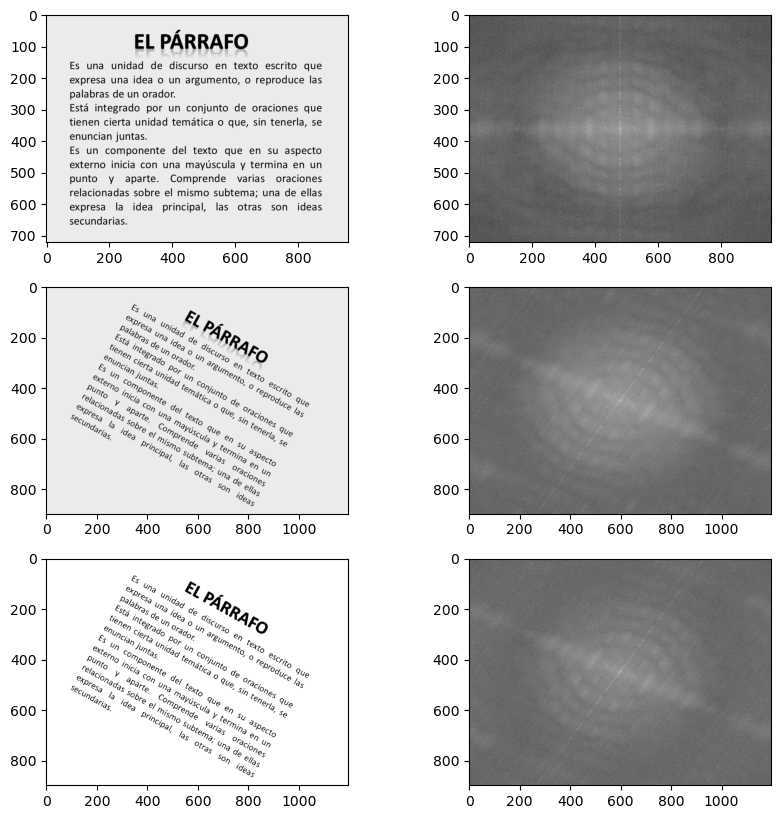

In [350]:
imagen0 = cv.imread("IMAGENES/parrafo0.jpg",cv.IMREAD_GRAYSCALE)
imagen1 = cv.imread("IMAGENES/parrafo1.jpg",cv.IMREAD_GRAYSCALE)


imagenaux = cv.threshold(imagen1,128,255,cv.THRESH_BINARY)[1]


mag,phase = mag_phase(np.fft.fft2(imagen0))
mag1,phase1 = mag_phase(np.fft.fft2(imagen1))

mag,ang = cv.cartToPolar(-1,0)

fig,ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(imagen0,cmap="gray")
ax[0,1].imshow(spectrum(imagen0),cmap="gray")

ax[1,0].imshow(imagen1,cmap="gray")
ax[1,1].imshow(spectrum(imagen1),cmap="gray")


ax[2,0].imshow(imagenaux,cmap="gray",vmin=0,vmax=255)
ax[2,1].imshow(spectrum(imagenaux),cmap="gray")
plt.show()